In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from PIL import Image

import matplotlib.pyplot as plt



In [4]:
# Configurations
device = "cuda" if torch.cuda.is_available() else "cpu"
train_dir = "../dataset/train"
test_dir = "../dataset/test"
img_size = 224
batch_size = 32

In [5]:
# Transformations for training dataset
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.4695, 0.4000, 0.3615], std=[0.2423, 0.2187, 0.2095]),

])
# Transformations for test/validation dataset
test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4695, 0.4000, 0.3615], std=[0.2423, 0.2187, 0.2095])

])

In [6]:
# Dataset & Dataloaders
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

In [7]:
# Split training dataset into training + validation subsets
val_ratio = 0.1
val_len = int(len(train_dataset) * val_ratio)
train_len = len(train_dataset) - val_len
train_subset, val_subset = random_split(train_dataset, [train_len, val_len])

In [8]:
# Create dataloaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
class_names = train_dataset.classes
num_classes = len(class_names)

In [9]:
# CNN Model
class CNNModel(nn.Module):
    """
    Simple Convolutional Neural Network (CNN) for image classification.

    Architecture:
    - 3 Convolutional layers with ReLU and MaxPooling
    - Dropout for regularization
    - 2 Fully connected layers
    """
    def __init__(self, num_classes):
        super( ).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)

        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 28 * 28, 1024)  
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)


        x = torch.flatten(x, 1)  
        x = self.dropout1(x)
        x = self.relu4(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x    

In [11]:
# Training Setup
model = CNNModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
# LOAD SAVED MODEL
model = CNNModel(num_classes).to(device)
model.load_state_dict(torch.load("./model_save", map_location=device))
model.eval()
print("✅ Model loaded successfully!")



✅ Model loaded successfully!


In [9]:
# Training & Validation Loop
train_losses = []
test_accuracies = []
for i in range (5):
    model.train()
    total_loss = 0
    for data , target in train_loader:
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()

        optimizer.step()
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(avg_loss)
        
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data) 
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

    accuracy = 100.0 * correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch {i}, Loss: {total_loss}, Test Accuracy: {accuracy:.2f}%")

0.19456498236651368
Epoch 0, Loss: 54.867325027356856, Test Accuracy: 97.80%
0.0391855591788689
Epoch 1, Loss: 11.05032768844103, Test Accuracy: 99.00%
0.0329601056702736
Epoch 2, Loss: 9.294749799017154, Test Accuracy: 99.00%
0.025937323923392906
Epoch 3, Loss: 7.314325346396799, Test Accuracy: 99.40%
0.021438446394842287
Epoch 4, Loss: 6.0456418833455245, Test Accuracy: 98.70%


In [14]:
torch.save(model.state_dict(), "./model_save")

In [13]:
# Evaluation Function
def ModelEvaluate(batch):
    """
    Evaluate the model on a given dataloader.

    Args:
        batch (DataLoader): DataLoader object (e.g., test_loader).
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in batch:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

    test_accuracy = 100.0 * correct / total
    print(f"\nFinal Test Accuracy: {test_accuracy:.2f}%")


In [ ]:
# Visualization
epochs = range(1, len(train_losses)+1)
plt.figure(figsize=(12,5))

# Plot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.legend()

# Plot 2: Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, 'g-o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy per Epoch')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
# Prediction Function
def predict_image(image_path, model, transform, class_names):
    """
    Predict the class of a single image.

    Args:
        image_path (str): Path to the image file
        model (nn.Module): Trained model
        transform (torchvision.transforms): Transformations to apply
        class_names (list): List of class names

    Returns:
        str: Predicted class label
    """
    model.eval()
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)

    predicted_class = class_names[predicted.item()]
    print(f"Predicted class: {predicted_class}")

    # Show image with prediction
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis("off")
    plt.show()

    return predicted_class


Predicted class: real


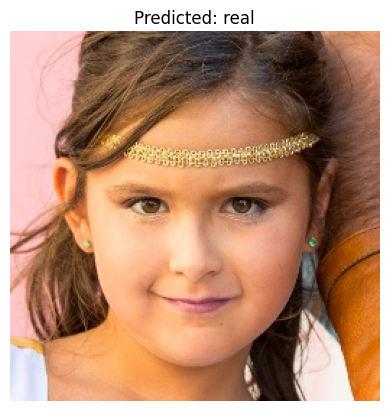

In [ ]:
image_path = "../classification.jpg"
predicted_class = predict_image(image_path, model, test_transform, class_names)

Predicted class: real


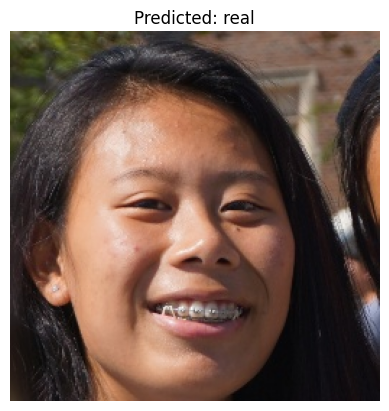

In [ ]:
image_path = "../ok.jpg"
predicted_class = predict_image(image_path, model, test_transform, class_names)